Make a map of residuals + calculate effects at centroids of the three call areas.

In [1]:
# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import DivergingNorm
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
### Establish higher res cartopy data
# import cartopy
# print(cartopy.config['data_dir'])

coastline_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m')
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')

states_50m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', '50m')

In [3]:
### Read coord, CA20, and WTK data
wtk_coords = np.loadtxt('data/wtk/coordinates_wtk.csv')
ca20_coords = np.loadtxt('data/ca20/coordinates_ca20.csv')
winds_all_wtk_interp = pd.read_csv("data/wtk/full_avg_wtk.csv")   # 07-13
winds_all_ca20 = np.loadtxt("data/ca20/full_avg_ca20.csv", delimiter=',')
winds_all_ca7 = np.loadtxt("data/ca20/full_avg_ca7.csv", delimiter=',')

# Cleanup
n_coords_ca20 = winds_all_ca20.shape[0]
winds_all_ca20 /= 100
winds_all_ca7 /= 100
winds_all_wtk_interp['Winds'] /= 100

In [4]:
### Calculate lat/long info for the map
lat_vec = ca20_coords[:,0]
long_vec = ca20_coords[:,1]

LAT_MIN = lat_vec.min()
LAT_MAX = lat_vec.max()
LAT_MEAN = lat_vec.mean()
LONG_MIN = long_vec.min()
LONG_MAX = long_vec.max()
LONG_MEAN = long_vec.mean()
MAP_BOUNDS = [LONG_MIN, LONG_MAX, LAT_MIN, LAT_MAX]

In [5]:
### Process shapefiles for lease regions
## Load shapefiles
df = gpd.read_file('data/shapefiles/CA_Call_Areas_2018_09_26.shp')

## Convert projection to match what we use in Cartopy
crs = ccrs.LambertConformal(central_longitude=LONG_MEAN, central_latitude=LAT_MEAN)
crs_proj4 = crs.proj4_init
df_proj = df.to_crs(crs_proj4)

## Merge (aka dissolve) geometries by lease area
df_proj_group = df_proj.dissolve(by='AREA_NM')

In [6]:
### Calculate "true" difference CA20 - WTK
diff20_vec = winds_all_ca20 - winds_all_wtk_interp['Winds']
diff20 = np.vstack((diff20_vec, ca20_coords.T)).T
diff20 = pd.DataFrame(diff20, columns=['Winds', 'Lat', 'Long'])

winds_all_wtk_interp = winds_all_wtk_interp.dropna()
diff20 = diff20.dropna()

In [7]:
### Calculate "estimated" difference from everything except renalysis product
## 20 year vs 7 year
diff_period = winds_all_ca20 - winds_all_ca7

## PBL
mynn2017 = np.loadtxt('data/ca20/year_2017.csv')
ysu2017 = np.loadtxt('data/sensitivity/WPS1-WRF3_year_2017.csv')
diff_pbl = (mynn2017 - ysu2017)/100

## WRF 3.4
wrf34 = np.loadtxt('data/sensitivity/OffshoreCA_6-10.csv')
diff_version = (ysu2017 - wrf34)/100

## SST
wps1 = np.loadtxt('data/ca20/year_2017.csv')
wps2 = np.loadtxt('data/sensitivity/WPS2-WRF1_year_2017.csv')
diff_sst = (wps1 - wps2)/100

## Forcing
era5 = np.loadtxt('data/sensitivity/WPS2-WRF1_year_2017.csv')
erai = np.loadtxt('data/sensitivity/OffshoreCA_5-1-100m_mean.csv')
diff_forcing = (era5 - erai)/100

## WTK2 / Region
wtk2 = pd.read_csv('data/sensitivity/wtkV2_2017_interp2boem.csv')
diff_region = mynn2017/100 - wtk2['Winds']

## Calculate the sum of factors
est_diff = diff_period + diff_pbl + diff_version + diff_sst + diff_forcing + diff_region

# Make a Map

In [8]:
### Regrid the estimated difference to match the NaNs in "diff20"
## Interpolate WTK winds onto BOEM grid
est_diff_regridded = interpolate.griddata(ca20_coords,
                              est_diff,
                              diff20[['Lat', 'Long']],
                              method='cubic')

/Users/orybchuk/opt/anaconda3/envs/wfp/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  from ipykernel import kernelapp as app
/Users/orybchuk/opt/anaconda3/envs/wfp/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
/Users/orybchuk/opt/anaconda3/envs/wfp/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
/Users/orybchuk/opt/anaconda3/envs/wfp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and wil

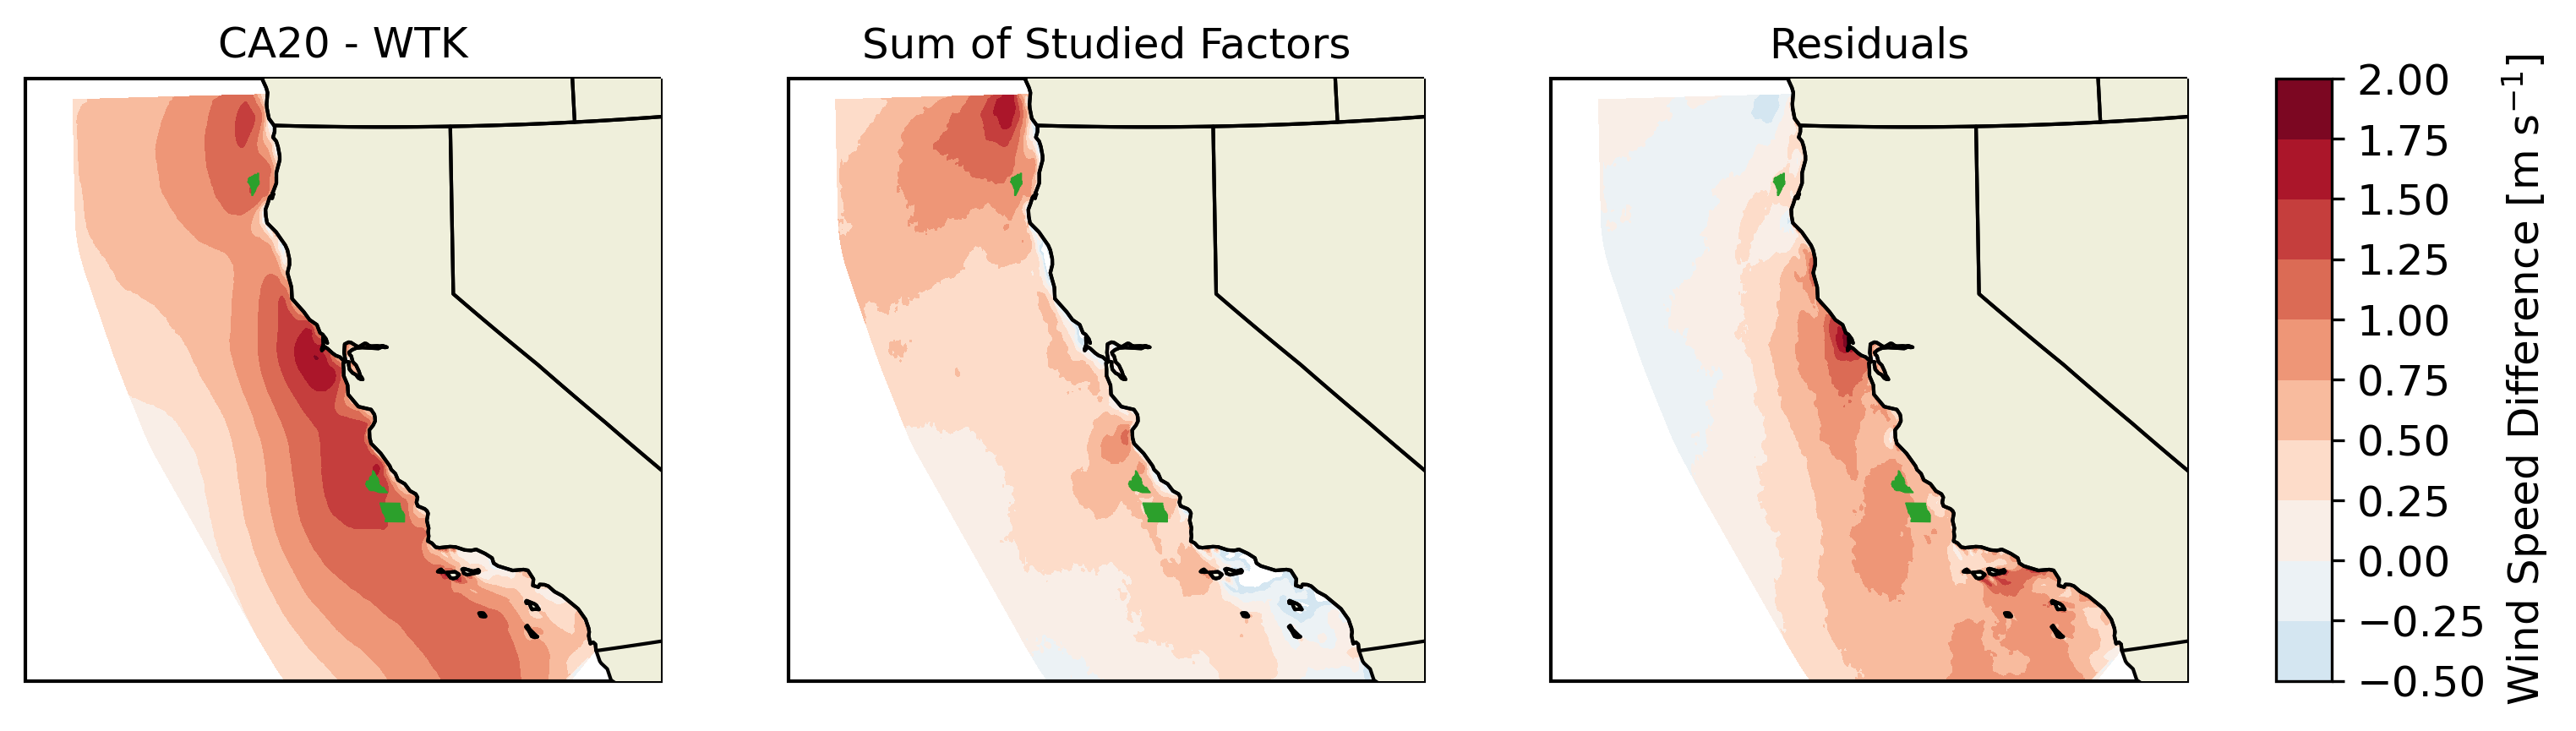

In [9]:
### Difference between CA20 and WTK
proj = ccrs.LambertConformal(central_longitude=LONG_MEAN, central_latitude=LAT_MEAN)
fig, ax = plt.subplots(1, 3, figsize=(11, 3.5), subplot_kw=dict(projection=proj),
                          sharex=True, sharey=True)

ax[0].set_extent(MAP_BOUNDS)

ticks_wind = np.linspace(3, 12, 10)
ticks_diff = np.linspace(-0.5, 2, 11)

im1 = ax[0].tricontourf(diff20['Long'],
                        diff20['Lat'],
                        diff20['Winds'],
                        ticks_diff, transform=ccrs.Geodetic(),
                        cmap=plt.cm.RdBu_r, norm=DivergingNorm(0, vmin=-2, vmax=2))
im2 = ax[1].tricontourf(long_vec,
                        lat_vec,
                        est_diff,
                        ticks_diff, transform=ccrs.Geodetic(),
                        cmap=plt.cm.RdBu_r, norm=DivergingNorm(0, vmin=-2, vmax=2))
im3 = ax[2].tricontourf(diff20['Long'],
                        diff20['Lat'],
                        diff20['Winds'] - est_diff_regridded,
                        ticks_diff, transform=ccrs.Geodetic(),
                        cmap=plt.cm.RdBu_r, norm=DivergingNorm(0, vmin=-2, vmax=2))



# Colorbar
cax2 = fig.add_axes([ax[-1].get_position().x0+0.26,ax[-1].get_position().y0,0.02,ax[-1].get_position().y1-ax[-1].get_position().y0])
cbar2 = fig.colorbar(im1, cax=cax2, ticks=ticks_diff)
cbar2.set_label('Wind Speed Difference [m s$^{-1}$]', fontsize=12)
cbar2.ax.tick_params(labelsize=12)

# Subtitles
ax[0].set_title("CA20 - WTK")
ax[1].set_title("Sum of Studied Factors")
ax[2].set_title("Residuals")

## Add map features
# Land
ax[0].add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')
ax[1].add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')
ax[2].add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')

# States
ax[0].add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')
ax[1].add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')
ax[2].add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')

ax[0].add_geometries(df_proj_group['geometry'], crs=crs, edgecolor='C2', facecolor='C2', linewidth=0.3)
ax[1].add_geometries(df_proj_group['geometry'], crs=crs, edgecolor='C2', facecolor='C2', linewidth=0.3)
ax[2].add_geometries(df_proj_group['geometry'], crs=crs, edgecolor='C2', facecolor='C2', linewidth=0.3)

# plt.savefig("../figures/fig09.png", bbox_inches='tight')

plt.show()

/Users/orybchuk/opt/anaconda3/envs/wfp/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  del sys.path[0]
/Users/orybchuk/opt/anaconda3/envs/wfp/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
/Users/orybchuk/opt/anaconda3/envs/wfp/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
/Users/orybchuk/opt/anaconda3/envs/wfp/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases lat

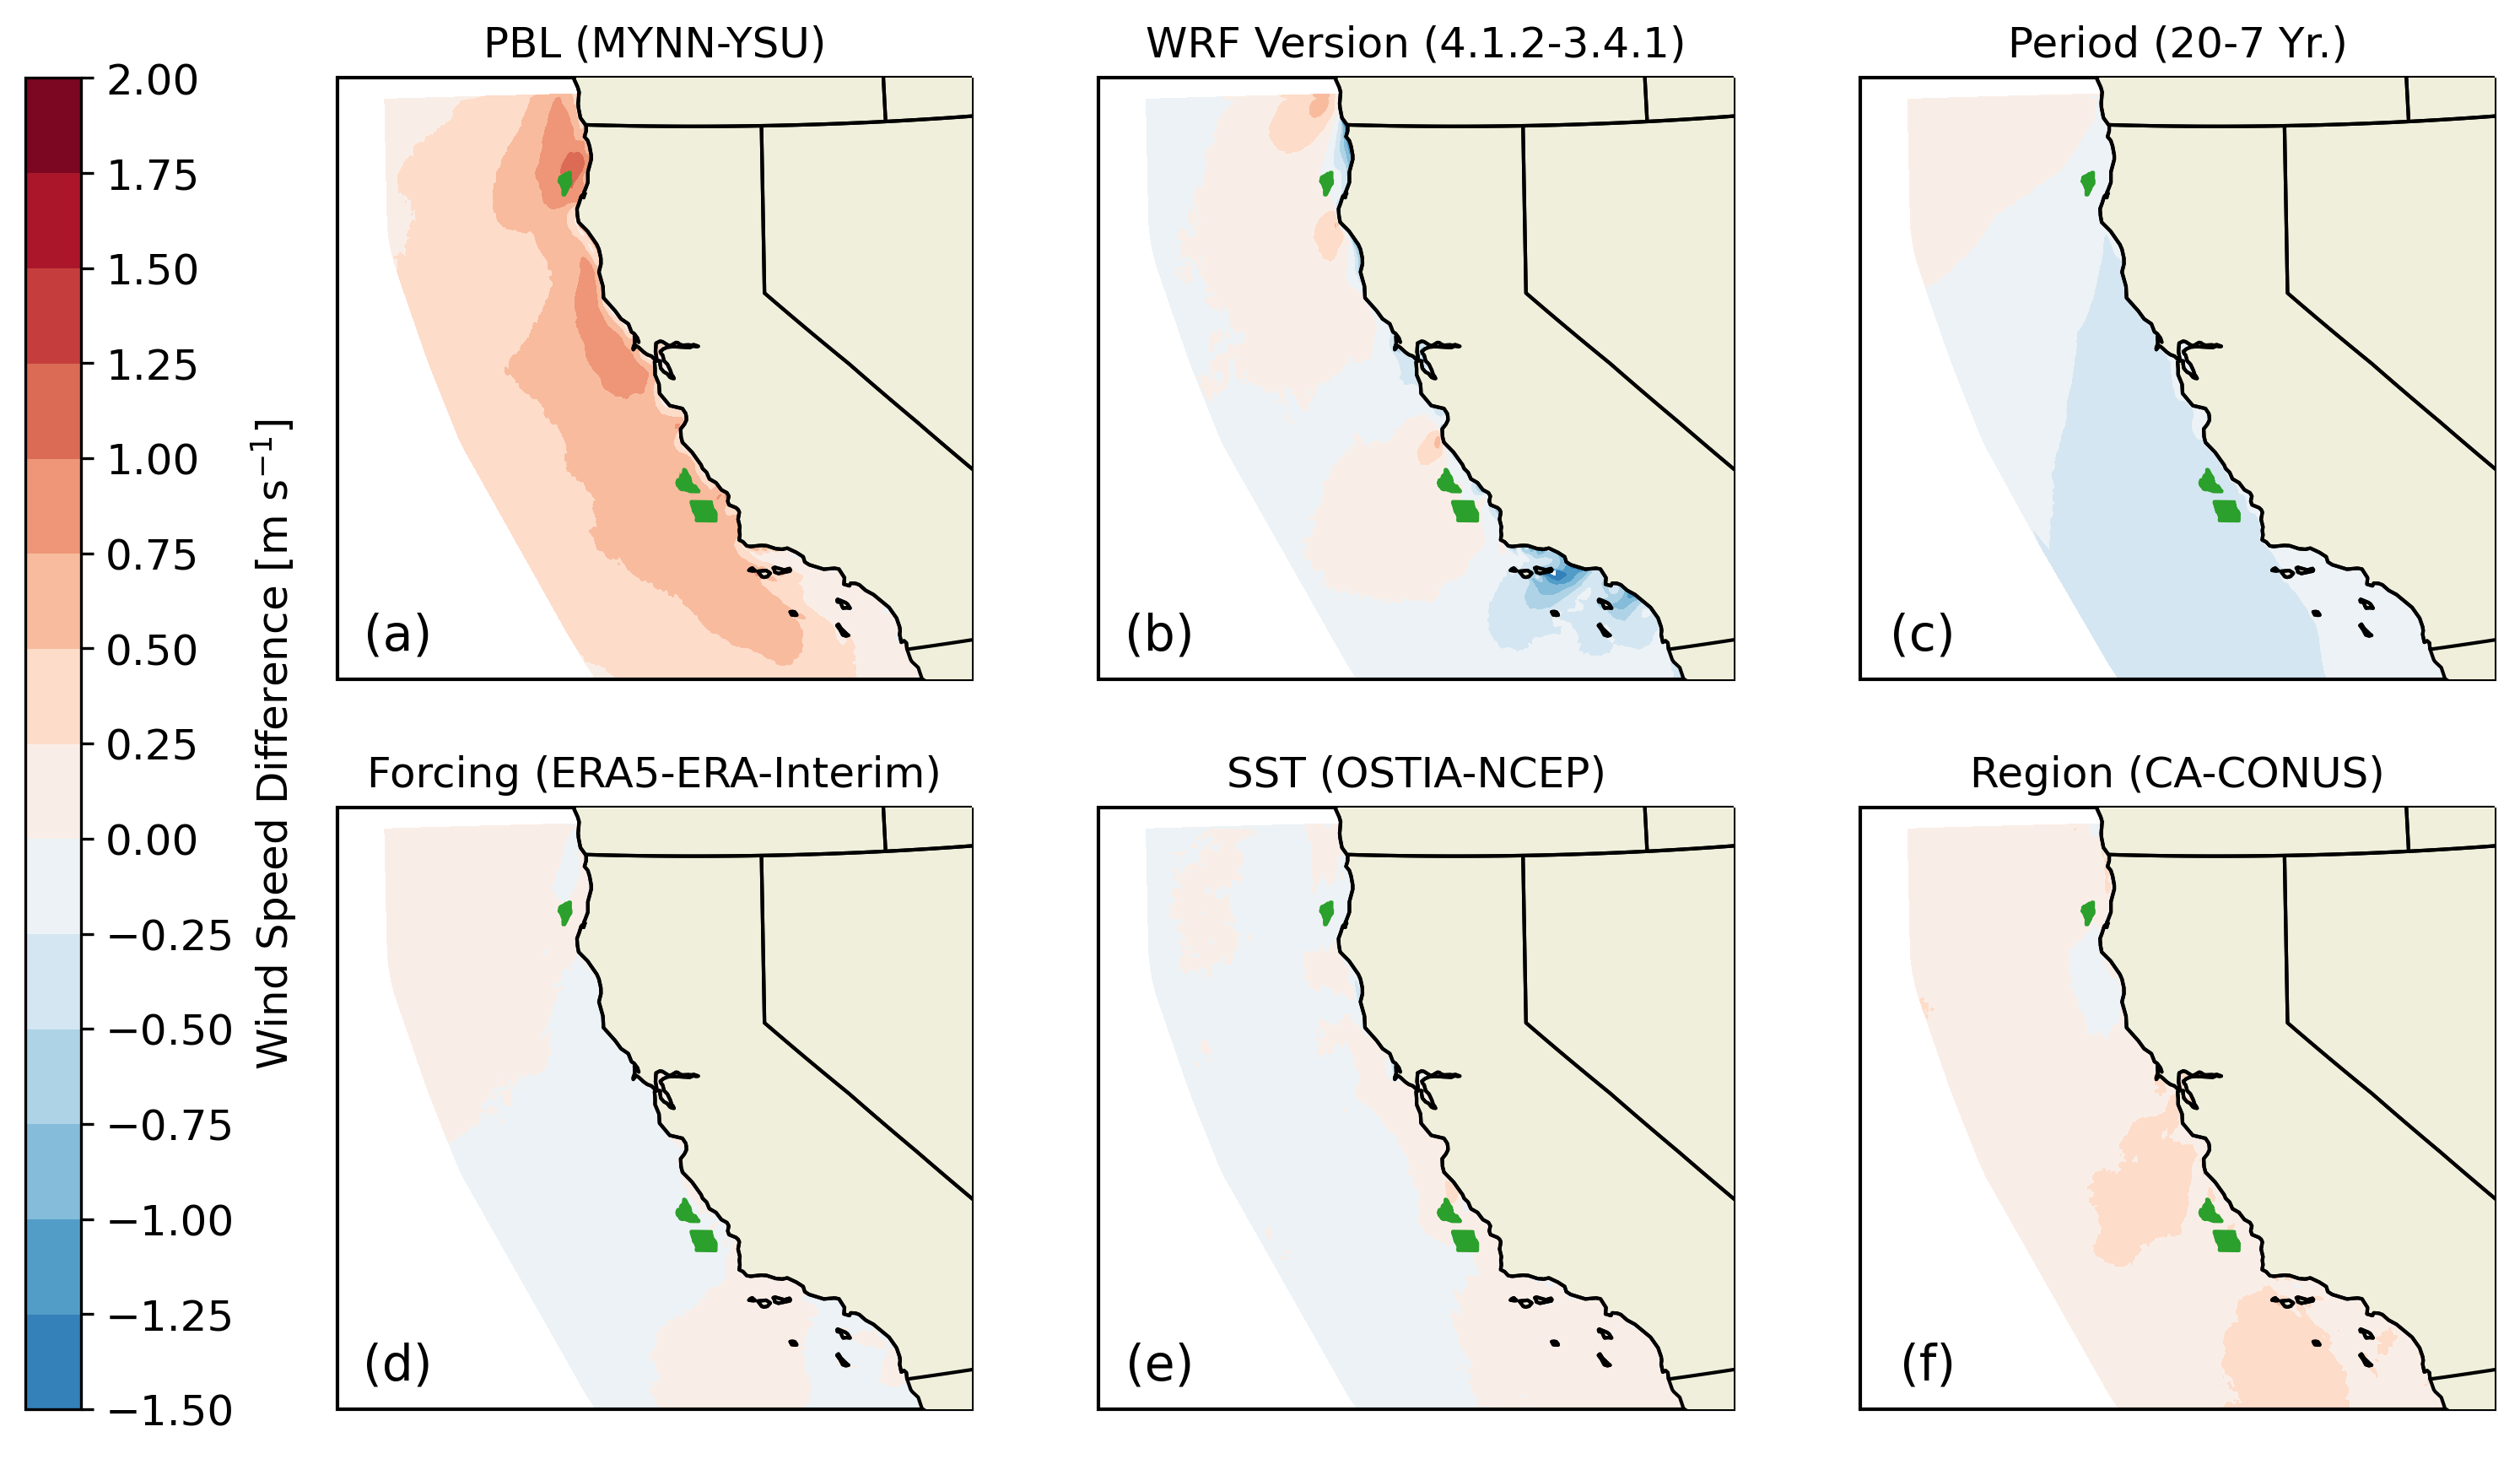

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(11, 7), subplot_kw=dict(projection=proj),
                          sharex=True, sharey=True)

ax[0,0].set_extent(MAP_BOUNDS)

ticks_wind = np.linspace(3, 12, 10)
ticks_diff = np.linspace(-1.5, 2, 15)

im1 = ax[0,0].tricontourf(long_vec,
                        lat_vec,
                        diff_pbl,
                        ticks_diff, transform=ccrs.Geodetic(),
                        cmap=plt.cm.RdBu_r, norm=DivergingNorm(0, vmin=-2, vmax=2))
im2 = ax[0,1].tricontourf(long_vec,
                        lat_vec,
                        diff_version,
                        ticks_diff, transform=ccrs.Geodetic(),
                        cmap=plt.cm.RdBu_r, norm=DivergingNorm(0, vmin=-2, vmax=2))
im3 = ax[0,2].tricontourf(long_vec,
                        lat_vec,
                        diff_period,
                        ticks_diff, transform=ccrs.Geodetic(),
                        cmap=plt.cm.RdBu_r, norm=DivergingNorm(0, vmin=-2, vmax=2))
im4 = ax[1,0].tricontourf(long_vec,
                        lat_vec,
#                         diff_sst,
                        diff_forcing,
                        ticks_diff, transform=ccrs.Geodetic(),
                        cmap=plt.cm.RdBu_r, norm=DivergingNorm(0, vmin=-2, vmax=2))
im5 = ax[1,1].tricontourf(long_vec,
                        lat_vec,
                        diff_sst,
                        ticks_diff, transform=ccrs.Geodetic(),
                        cmap=plt.cm.RdBu_r, norm=DivergingNorm(0, vmin=-2, vmax=2))
im6 = ax[1,2].tricontourf(long_vec,
                        lat_vec,
                        diff_region,
                        ticks_diff, transform=ccrs.Geodetic(),
                        cmap=plt.cm.RdBu_r, norm=DivergingNorm(0, vmin=-2, vmax=2))

# Colorbar
cax = fig.add_axes([ax[-1,0].get_position().x1-0.34,ax[-1,0].get_position().y0,0.02,ax[0,0].get_position().y1-ax[-1,0].get_position().y0])
cbar = fig.colorbar(im1, cax=cax, ticks=ticks_diff)
cbar.set_label('Wind Speed Difference [m s$^{-1}$]', fontsize=12)
cbar.ax.tick_params(labelsize=12)

# Subtitles
ax[0,0].set_title("PBL (MYNN-YSU)")
ax[0,1].set_title("WRF Version (4.1.2-3.4.1)")
ax[0,2].set_title("Period (20-7 Yr.)")
ax[1,0].set_title("Forcing (ERA5-ERA-Interim)")
ax[1,1].set_title("SST (OSTIA-NCEP)")
ax[1,2].set_title("Region (CA-CONUS)")

## Add map features
# Land
ax[0,0].add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')
ax[0,1].add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')
ax[0,2].add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')
ax[1,0].add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')
ax[1,1].add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')
ax[1,2].add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')

# States
ax[0,0].add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')
ax[0,1].add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')
ax[0,2].add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')
ax[1,0].add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')
ax[1,1].add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')
ax[1,2].add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')

ax[0,0].add_geometries(df_proj_group['geometry'], crs=crs, edgecolor='C2', facecolor='C2')
ax[0,1].add_geometries(df_proj_group['geometry'], crs=crs, edgecolor='C2', facecolor='C2')
ax[0,2].add_geometries(df_proj_group['geometry'], crs=crs, edgecolor='C2', facecolor='C2')
ax[1,0].add_geometries(df_proj_group['geometry'], crs=crs, edgecolor='C2', facecolor='C2')
ax[1,1].add_geometries(df_proj_group['geometry'], crs=crs, edgecolor='C2', facecolor='C2')
ax[1,2].add_geometries(df_proj_group['geometry'], crs=crs, edgecolor='C2', facecolor='C2')

ax[0,0].text(0.15,
          0.05,
          '(a)',
          fontsize=14,
          transform = ax[0,0].transAxes,
          horizontalalignment='right')
ax[0,1].text(0.15,
          0.05,
          '(b)',
          fontsize=14,
          transform = ax[0,1].transAxes,
          horizontalalignment='right')
ax[0,2].text(0.15,
          0.05,
          '(c)',
          fontsize=14,
          transform = ax[0,2].transAxes,
          horizontalalignment='right')
ax[1,0].text(0.15,
          0.05,
          '(d)',
          fontsize=14,
          transform = ax[1,0].transAxes,
          horizontalalignment='right')
ax[1,1].text(0.15,
          0.05,
          '(e)',
          fontsize=14,
          transform = ax[1,1].transAxes,
          horizontalalignment='right')
ax[1,2].text(0.15,
          0.05,
          '(f)',
          fontsize=14,
          transform = ax[1,2].transAxes,
          horizontalalignment='right')

# plt.savefig("../figures/fig06.png", bbox_inches='tight')

plt.show()